In [1]:
import numpy
import diffrax
import jax
import jax.numpy as np
import collocation
import model
import continuation
import scipy.integrate
import matplotlib.pyplot as plt
import warnings
from functools import partial
jax.config.update("jax_enable_x64", True)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
@jax.jit
def compute_mesh(density, mesh_old):
    
    cum = np.cumsum(density * (mesh_old[1:] - mesh_old[:-1]) / 2)
    cum = cum / cum[-1]
    cum = np.pad(cum, ((1, 0)))
    
    def loop_body(_, y):
        i = np.searchsorted(cum, y)
        return _, ((cum[i] - cum[i - 1]) / (mesh_old[i] - mesh_old[i - 1])) * (y - cum[i - 1]) + mesh_old[i - 1]
        
    mesh = jax.lax.scan(loop_body, init=0, xs=np.linspace(cum[0], cum[-1], mesh_old.size)[1:-1])[1]
    mesh = np.concatenate([np.array([0]), mesh, np.array([1])])
    return mesh

In [229]:
br = model.Brusselator(np.array([1, 5, 1]))

In [230]:
testint = scipy.integrate.solve_ivp(br.f, jac=br.jac, t_span=(0, 50), y0=np.array([1, 1]), method="BDF")

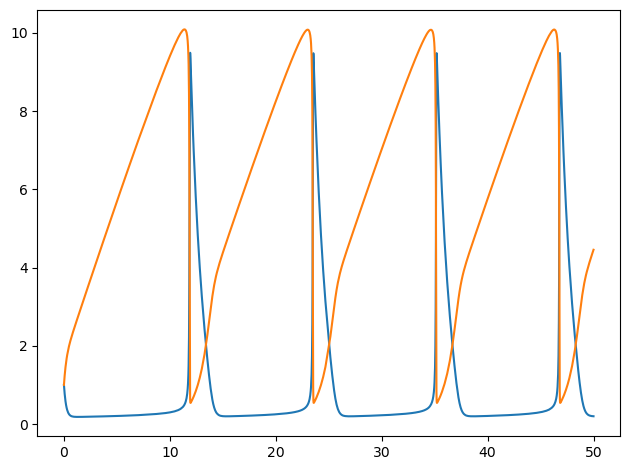

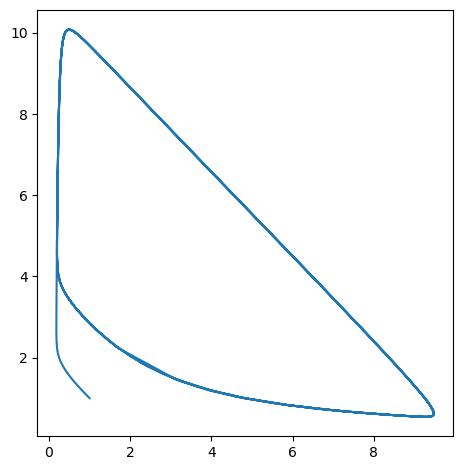

In [231]:
plt.plot(testint.t, testint.y.T)
plt.tight_layout()
plt.show()
plt.gca().set_aspect(1)
plt.plot(*testint.y)
plt.tight_layout()
plt.show()

In [239]:
n_mesh_point = 150
period0 = 2 * np.pi / np.abs(np.linalg.eigvals(br.jac(0., np.array([1., 3])))[0].imag)
period0 = 12.
orbit0 = scipy.integrate.solve_ivp(br.f, jac=br.jac, t_span=(0, period0), t_eval=np.linspace(0, period0, n_mesh_point * collocation.colloc.n_colloc_point + 1), y0=testint.y[:, -1], method="BDF")

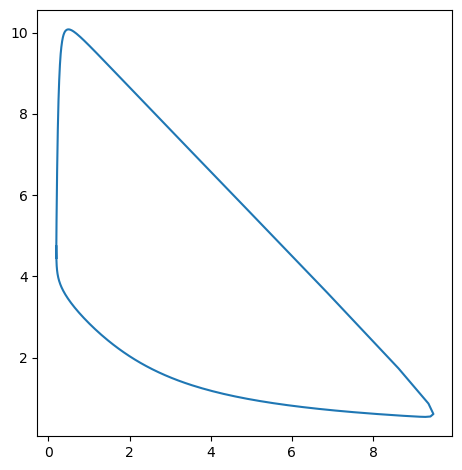

In [240]:
plt.plot(*orbit0.y)
plt.gca().set_aspect(1)
plt.tight_layout()
plt.show()

In [241]:
p0 = np.array([period0, 0])
y0 = orbit0.y
args=(np.zeros(y0.size + p0.size).at[-1].set(1), y0.ravel(order="F"), p0, y0.ravel(order="F"), p0, br, np.array([0, 0, 1]))
solver = collocation.colloc(continuation.f_rc, continuation.fp_rc, y0, p0, args)
solver.damped_newton()
print(solver.err)

2.6616959319005528e-08


In [242]:
solver._newton_step()
solver.err

Array(7.20540592e-12, dtype=float64)

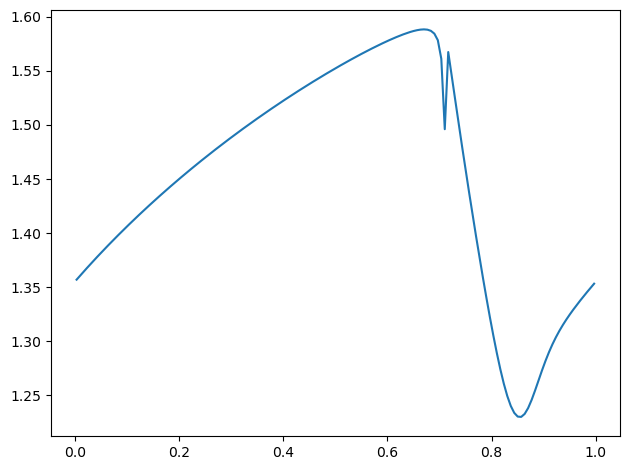

In [243]:
plt.plot((solver.mesh_points[:-1] + solver.mesh_points[1:]) / 2, solver.truncation_error_estimate())
plt.tight_layout()
plt.show()

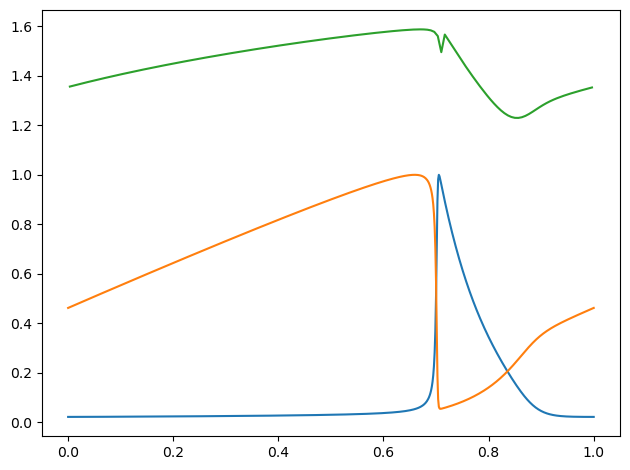

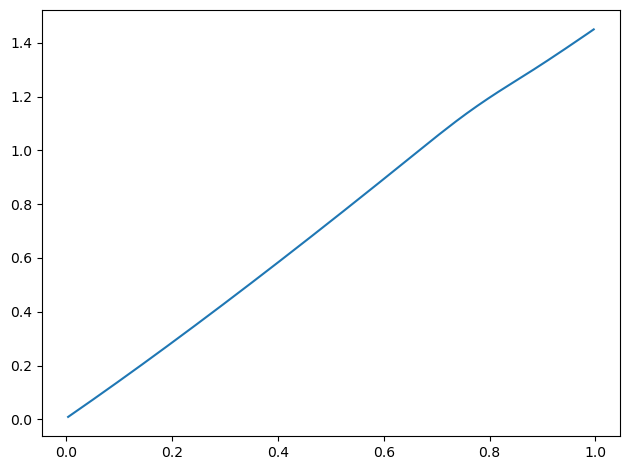

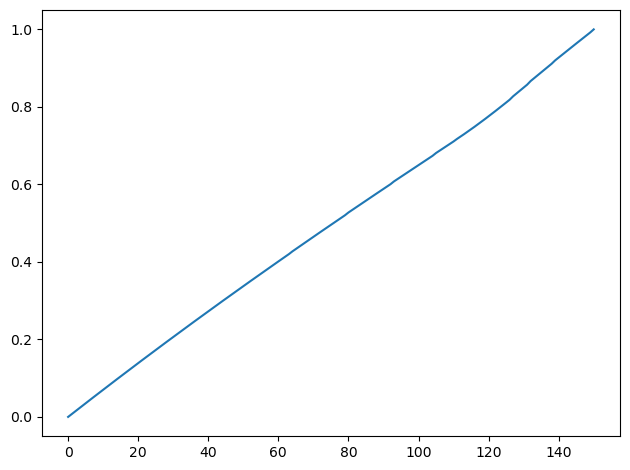

In [244]:
plt.plot(solver.t, solver.y.T / np.max(np.abs(solver.y), axis=1))
plt.tight_layout()
# defect = solver.resid()[:solver.y.size].reshape(solver.y.shape, order="F")
# density = np.maximum((np.linalg.norm(defect, axis=0) / np.max(np.linalg.norm(defect, axis=0)))**(1/6), 1 / (10 * solver.n_mesh_point))
density = solver.truncation_error_estimate()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, density)
plt.tight_layout()
plt.show()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, np.cumsum(density * (solver.mesh_points[1:] - solver.mesh_points[:-1])))
plt.tight_layout()
plt.show()
plt.plot(compute_mesh(density, solver.mesh_points))
plt.tight_layout()
plt.show()

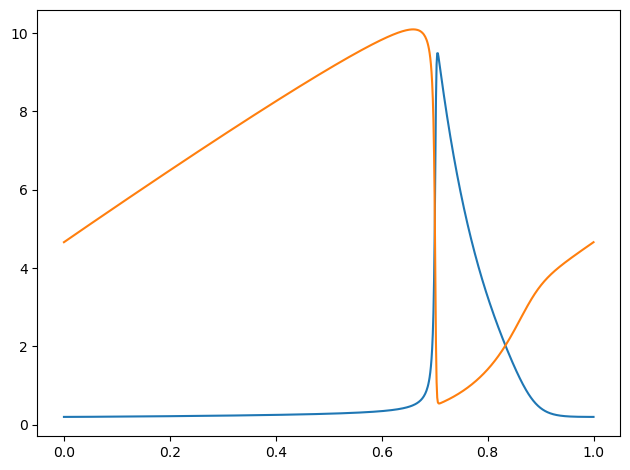

In [245]:
mesh_new = compute_mesh(density, solver.mesh_points)
t_new = np.concatenate([np.ravel(np.linspace(0, 1, solver.n_colloc_point + 1)[:-1] * np.reshape(mesh_new[1:] - mesh_new[:-1], (solver.n_mesh_point, 1))\
                    + mesh_new[:-1].reshape((solver.n_mesh_point, 1))), np.array([mesh_new[-1]])])
plt.plot(t_new, solver.y_interp(t_new).T)
plt.tight_layout()
plt.show()

In [170]:
solver.y = solver.y_interp(t_new)
solver.args = (np.zeros(solver.y.size + solver.p.size).at[-1].set(1), solver.y.ravel(order="F"), solver.p, solver.y.ravel(order="F"), solver.p, br, np.array([0, 0, 1]))
solver.update_mesh(mesh_new)

In [45]:
solver.solve()
print(solver.err)

2.797697620157056e-11


In [15]:
solver._newton_step()
solver.err

Array(1.11501901e-11, dtype=float64)

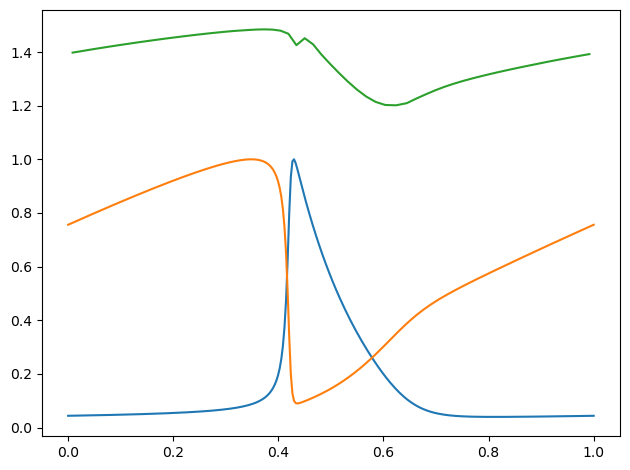

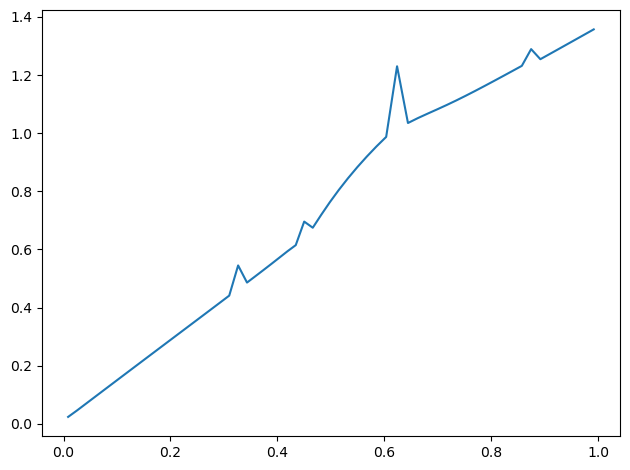

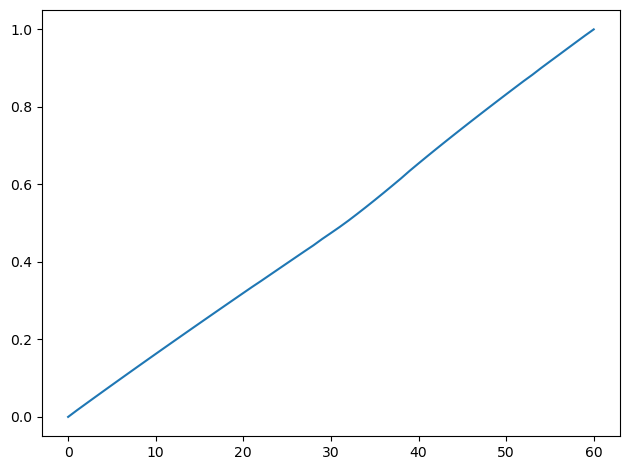

In [16]:
plt.plot(solver.t, solver.y.T / np.max(np.abs(solver.y), axis=1))
plt.tight_layout()
# defect = solver.resid()[:solver.y.size].reshape(solver.y.shape, order="F")
# density = np.maximum((np.linalg.norm(defect, axis=0) / np.max(np.linalg.norm(defect, axis=0)))**(1/6), 1 / (10 * solver.n_mesh_point))
density = solver.truncation_error_estimate()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, density)
plt.tight_layout()
plt.show()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, np.cumsum(density) * (solver.mesh_points[1:] - solver.mesh_points[:-1]))
plt.tight_layout()
plt.show()
plt.plot(compute_mesh(density, solver.mesh_points))
plt.tight_layout()
plt.show()

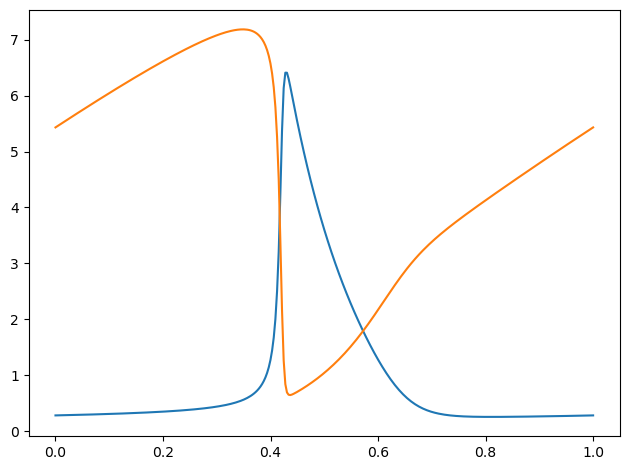

In [17]:
mesh_new = compute_mesh(density, solver.mesh_points)
t_new = np.concatenate([np.ravel(np.linspace(0, 1, solver.n_colloc_point + 1)[:-1] * np.reshape(mesh_new[1:] - mesh_new[:-1], (solver.n_mesh_point, 1))\
                    + mesh_new[:-1].reshape((solver.n_mesh_point, 1))), np.array([mesh_new[-1]])])
plt.plot(t_new, solver.y_interp(t_new).T)
plt.tight_layout()
plt.show()

In [249]:
p0 = np.array([period0, 0])
y0 = orbit0.y
args=(np.zeros(y0.size + p0.size).at[-1].set(1), y0.ravel(order="F"), p0, y0.ravel(order="F"), p0, br, np.array([0, 0, 1]))
solver = collocation.colloc(continuation.f_rc, continuation.fp_rc, y0, p0, args)

In [250]:
test3 = continuation.cont(solver, p_max=np.log(10), p_min=-4.6)

In [251]:
np.max(test3[1][:, 1])

Array(1.01218867, dtype=float64)

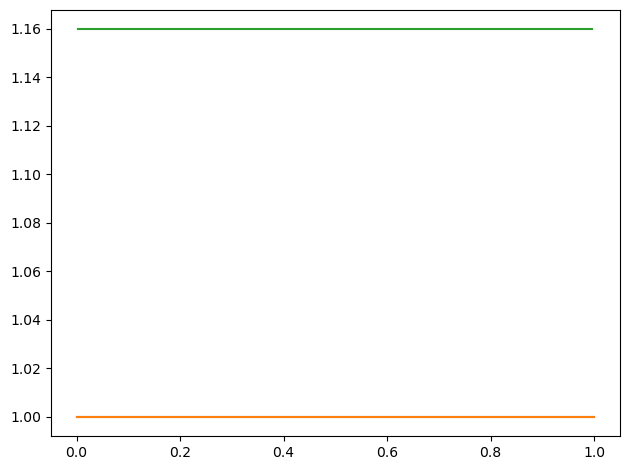

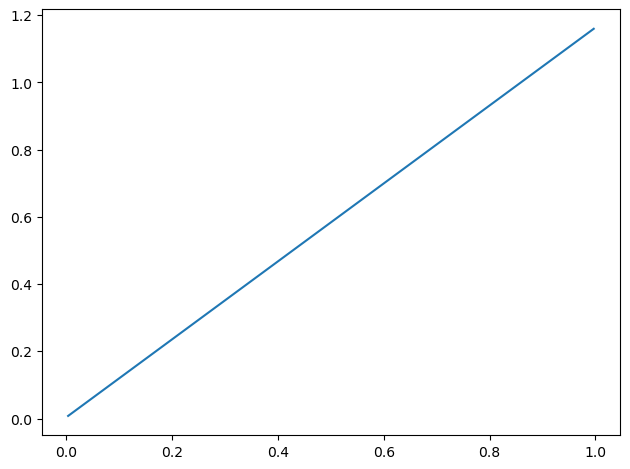

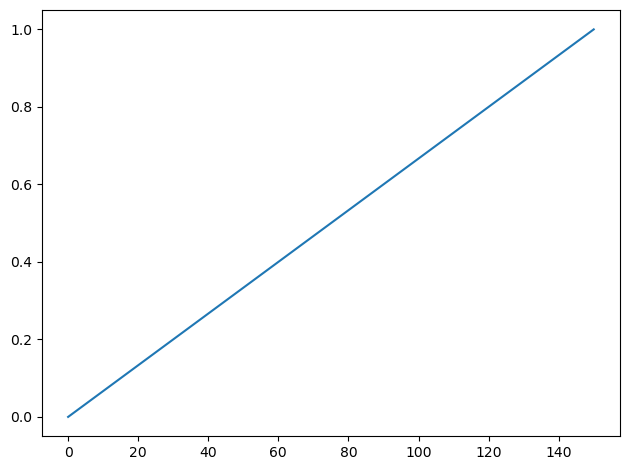

In [224]:
plt.plot(solver.t, solver.y.T / np.max(np.abs(solver.y), axis=1))
plt.tight_layout()
# defect = solver.resid()[:solver.y.size].reshape(solver.y.shape, order="F")
# density = np.maximum((np.linalg.norm(defect, axis=0) / np.max(np.linalg.norm(defect, axis=0)))**(1/6), 1 / (10 * solver.n_mesh_point))
density = solver.truncation_error_estimate()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, density)
plt.tight_layout()
plt.show()
plt.plot((solver.mesh_points[1:] + solver.mesh_points[:-1]) / 2, np.cumsum(density) * (solver.mesh_points[1:] - solver.mesh_points[:-1]))
plt.tight_layout()
plt.show()
plt.plot(compute_mesh(density, solver.mesh_points))
plt.tight_layout()
plt.show()

In [225]:
p0 = np.array([period0, 0])
y0 = orbit0.y
args=(np.zeros(y0.size + p0.size).at[-1].set(1), y0.ravel(order="F"), p0, y0.ravel(order="F"), p0, br, np.array([0, 0, 1]))
solver = collocation.colloc(continuation.f_rc, continuation.fp_rc, y0, p0, args)

In [226]:
test3_1 = continuation.cont(solver, p_max=np.log(3), p_min=np.log(0.65), step_size=-1e-2)

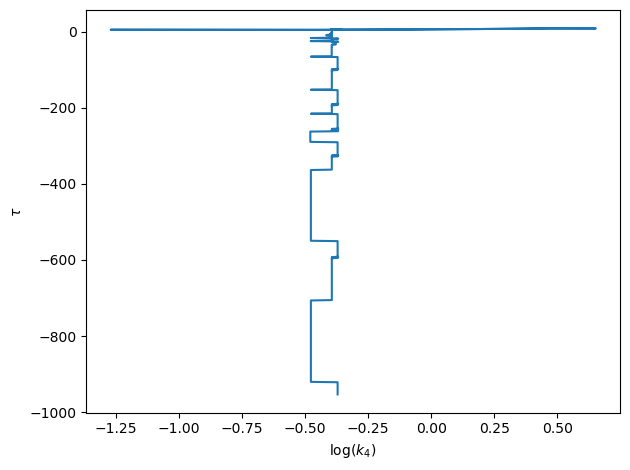

In [227]:
plt.plot(np.log(br.reaction_consts[2]) + np.concatenate([test3_1[1][-2:1:-1, 1], test3[1][1:-1, 1]]), np.concatenate([test3_1[1][-2:1:-1, 0], test3[1][1:-1, 0]]))
plt.xlabel("$\log(k_4)$")
plt.ylabel("$\\tau$")
plt.tight_layout()
# plt.savefig("brusselator_cont_k4_period.pdf", bbox_inches=0, transparent=True)
plt.show()

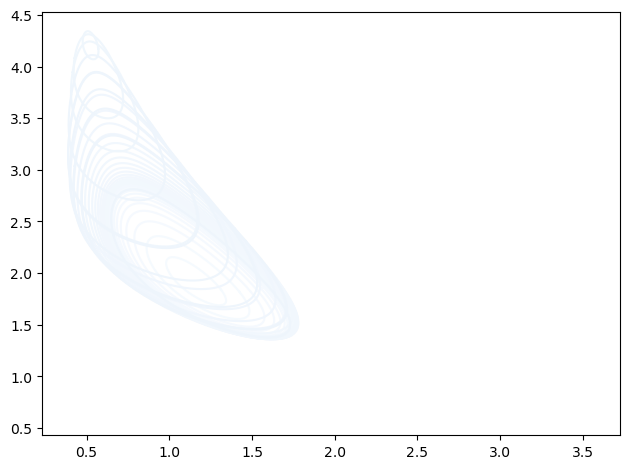

In [228]:
orbits3 = np.vstack([test3_1[0][-2::-1], test3[0][:-1]])
c = plt.cm.Blues(np.linspace(0, 1, orbits3.shape[0]))
for i in range(orbits3.shape[0]):
    plt.plot(*orbits3[i], c=c[i])
    
plt.tight_layout()
# plt.savefig("brusselator_cont_k4_lc.pdf", bbox_inches=0, transparent=True)
plt.show()

In [642]:
p0 = np.array([period0, 0])
y0 = orbit0.y
args=(np.zeros(y0.size + p0.size).at[-1].set(1), y0.ravel(order="F"), p0, y0.ravel(order="F"), p0, br, np.array([0, 1, 0]))
solver = collocation.colloc(continuation.f_rc, continuation.fp_rc, y0, p0, args)

In [643]:
test2 = continuation.cont(solver, p_max=np.log(3), p_min=-0.39, step_size=-1e-2)

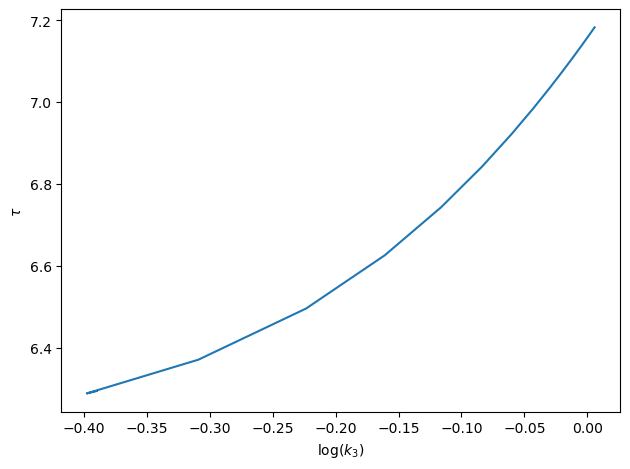

In [644]:
plt.plot(test2[1][1:, 1], test2[1][1:, 0])
plt.xlabel("$\log(k_3)$")
plt.ylabel("$\\tau$")
plt.tight_layout()
# plt.savefig("brusselator_cont_k3_period.pdf", bbox_inches=0, transparent=True)
plt.show()

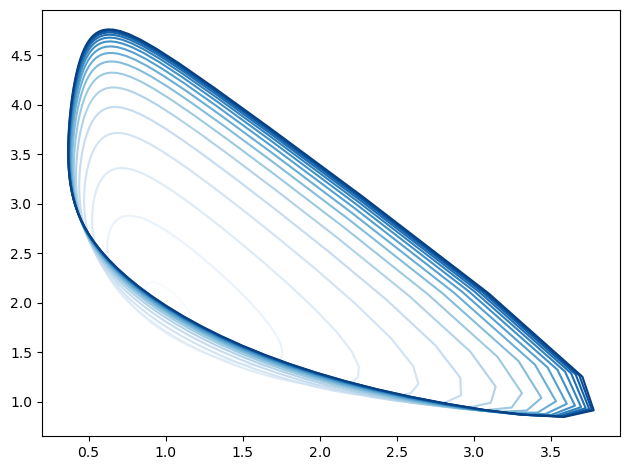

In [645]:
c = plt.cm.Blues(np.linspace(0, 1, test2[0].shape[0] - 1)[::-1])
for i in range(test2[0].shape[0] - 2, 0, -1):
    plt.plot(*test2[0][i], c=c[i])

plt.tight_layout()
# plt.savefig("brusselator_cont_k3_lc.pdf", bbox_inches=0, transparent=True)
plt.show()

In [17]:
p0 = np.array([period0, 0])
y0 = orbit0.y
args=(np.zeros(y0.size + p0.size).at[-1].set(1), y0.ravel(order="F"), p0, y0.ravel(order="F"), p0, br, np.array([1, 0, 0]))
solver = collocation.colloc(continuation.f_rc, continuation.fp_rc, y0, p0, args)

In [18]:
test1 = continuation.cont(solver, p_max=0.69, p_min=-2.3, step_size=1e-2)

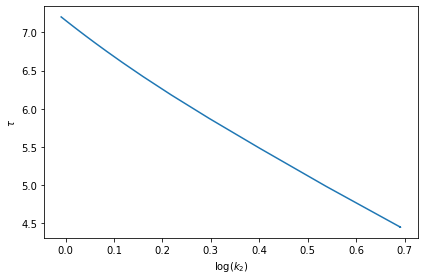

In [70]:
plt.plot(test1[1][1:, 1], test1[1][1:, 0])
plt.xlabel("$\log(k_2)$")
plt.ylabel("$\\tau$")
plt.tight_layout()
# plt.savefig("brusselator_cont_k2_period.pdf", bbox_inches=0, transparent=True)
plt.show()

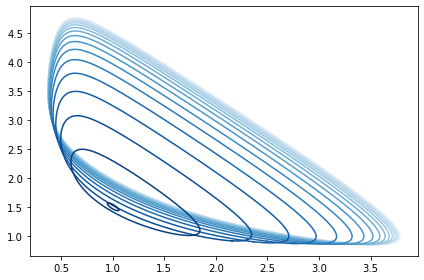

In [72]:
c = plt.cm.Blues(np.linspace(0, 1, test1[0].shape[0] - 1))
for i in range(test1[0].shape[0] - 1):
    plt.plot(*test1[0][i], c=c[i])

plt.tight_layout()
# plt.savefig("brusselator_cont_k2_lc.pdf", bbox_inches=0, transparent=True)
plt.show()

In [21]:
traj = np.array([np.vstack([np.load("/home/ccchi/project/KaiODE/v6_sna/brusselator1/brusselator_%d_%d.npy"%(i, j))[::5] for i in range(1, 107)]) for j in range(10)])
traj_concat = np.vstack(traj)

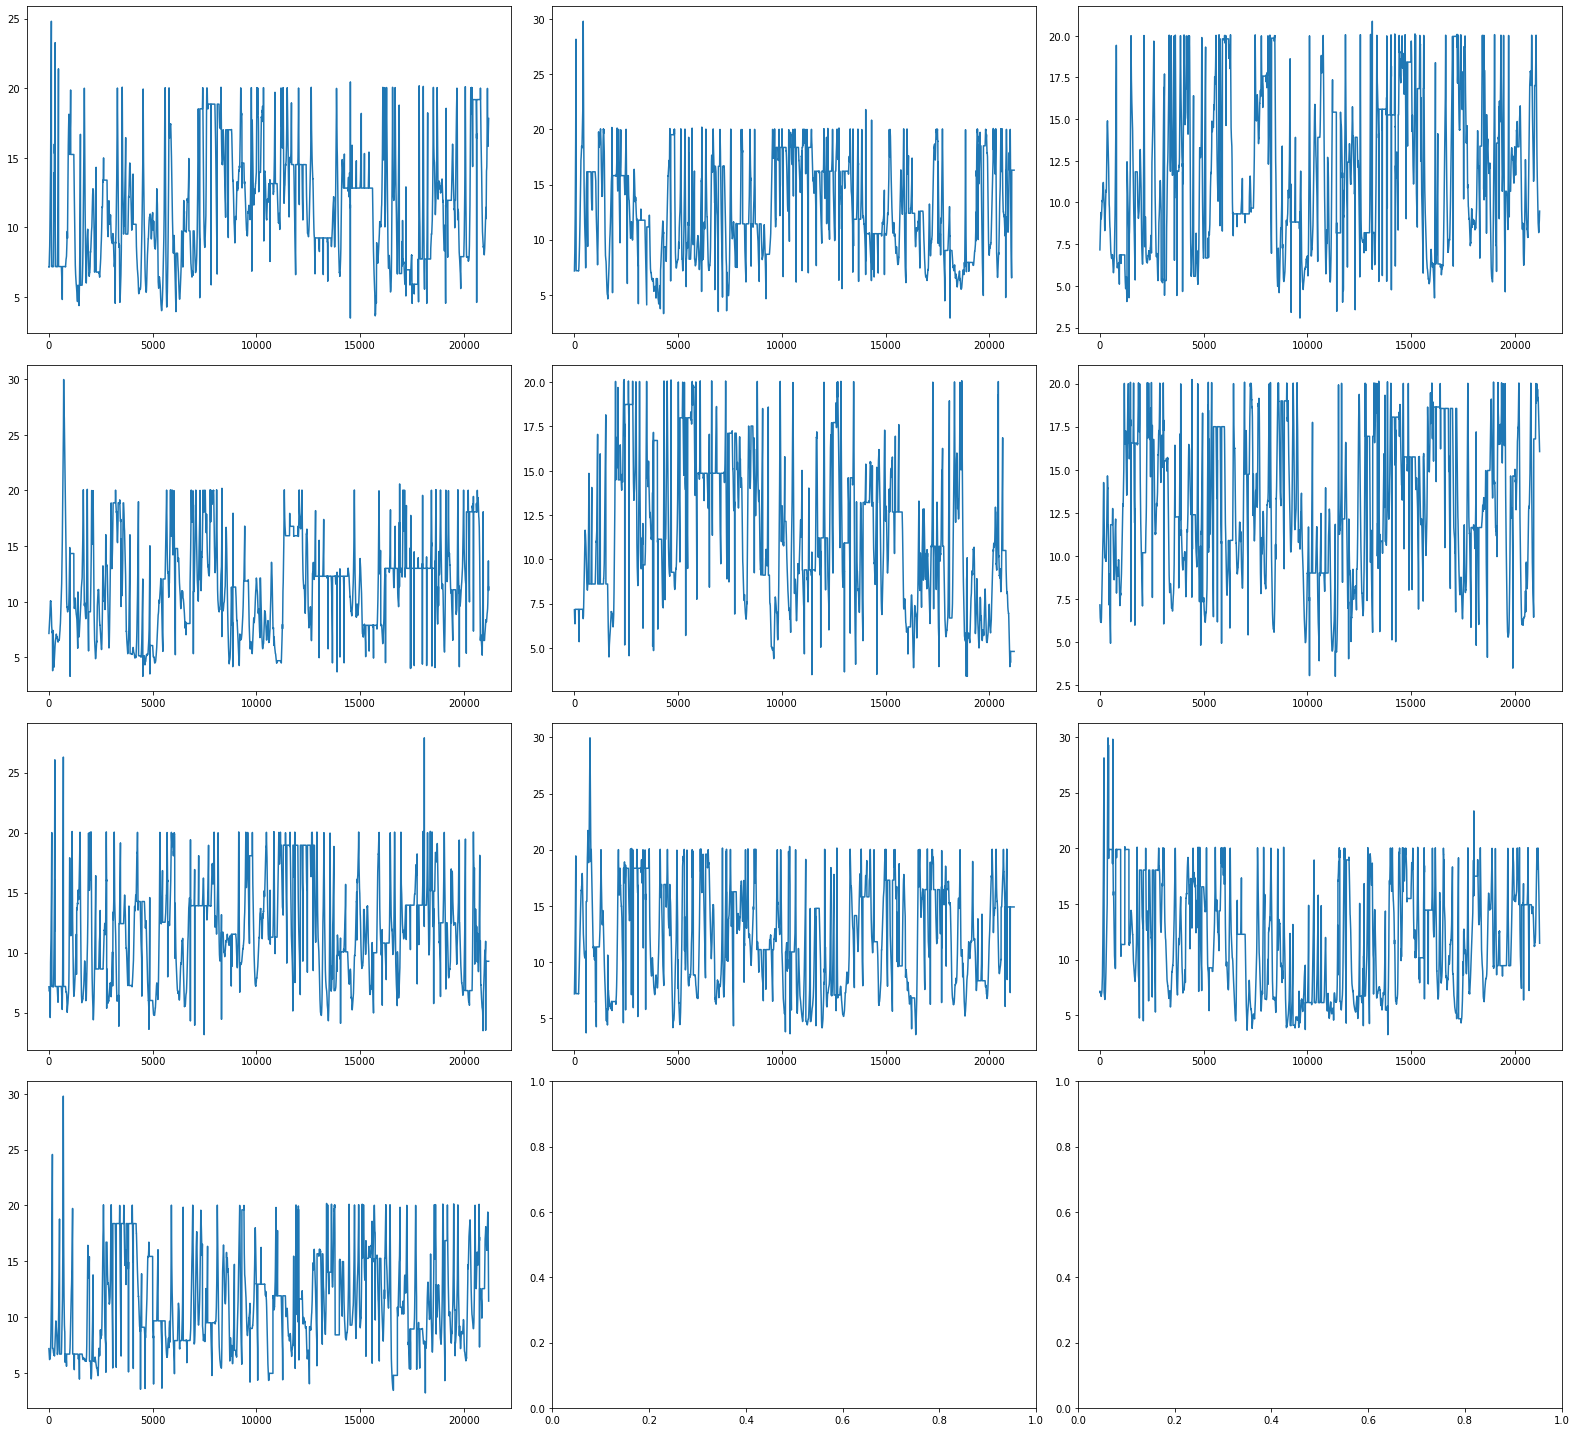

In [22]:
fig, ax = plt.subplots(4, 3, figsize=(22, 20))
for i in range(traj.shape[0]):
    ax[i//3, i%3].plot(traj[i, :, -1])
plt.tight_layout()
plt.show()

/home/ccchi/.conda/envs/jax/lib/python3.10/site-packages/mpl_toolkits/mplot3d/proj3d.py:113: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


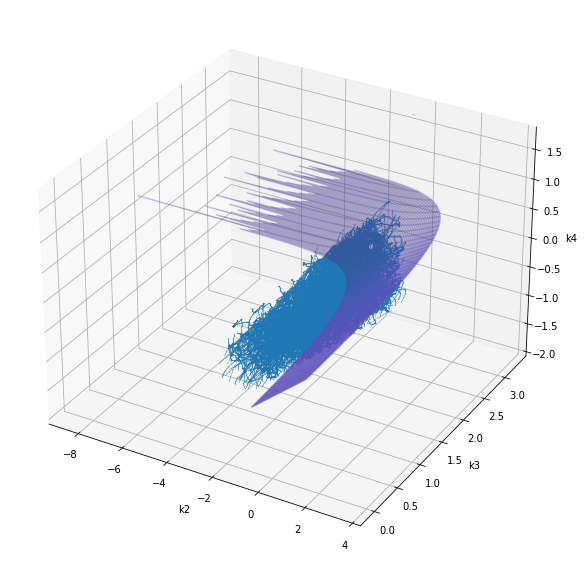

In [23]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.set_xlabel("k2")
ax.set_ylabel("k3")
ax.set_zlabel("k4")
ax.plot(*traj_concat[:, :3].T, ".", markersize=0.33)

plotpoints = 1000
y = np.outer(np.linspace(1, np.log(6), plotpoints), np.ones(plotpoints))
z = np.outer(np.ones(plotpoints), np.linspace(-2, np.log(6), plotpoints))
x = np.log(np.exp(y) * np.exp(z)**2 - np.exp(z)**3)

ax.plot_wireframe(x, y, z, color="slateblue", alpha=0.33)
ax.plot_surface(x, y, z, color="slateblue", alpha=0.25)

plt.tight_layout()
plt.show()

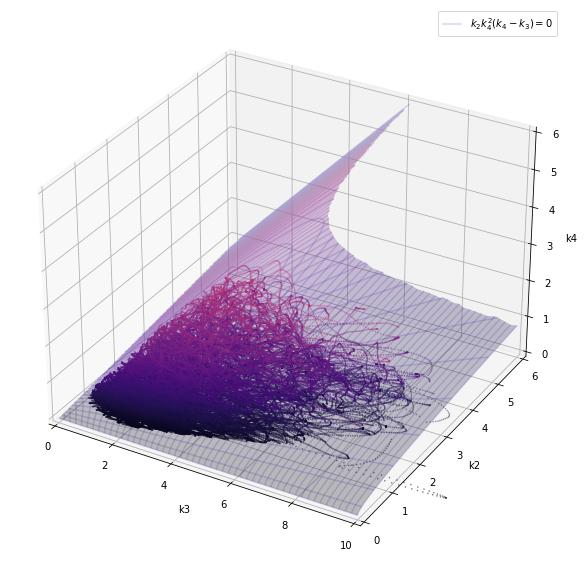

In [80]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.set_ylabel("k2")
ax.set_xlabel("k3")
ax.set_zlabel("k4")
c = plt.cm.magma(np.exp(traj_concat[::, 2]) / 6)
ax.scatter(*np.exp(traj_concat[::, np.array([1, 0, 2])].T), ".", s=0.33, c=c)

plotpoints = 1000
y = np.outer(np.linspace(0, 10, plotpoints), np.ones(plotpoints))
z = np.outer(np.ones(plotpoints), np.linspace(0, 6, plotpoints))
x = y * z**2 - z**3
x = x.at[x < 0].set(np.nan)
x = x.at[x > 6].set(np.nan)

ax.plot_wireframe(y, x, z, color="slateblue", alpha=0.25, label="$k_2k_4^2(k_4-k_3) = 0$")
ax.plot_surface(y, x, z, cmap="magma", alpha=0.25)
ax.set_xlim((0, 10))
ax.set_ylim((0, 6))
ax.set_zlim((0, 6))

plt.legend()
plt.tight_layout()
# plt.savefig("brusselator_lc_sample.png", bbox_inches=0, transparent=True, dpi=300)
plt.show()

In [30]:
np.exp(np.log(3) + 1)

DeviceArray(8.15484549, dtype=float64, weak_type=True)